It is a type of collaborative filtering that focuses on the similarity between items rather than users. The goal of item-based collaborative filtering is to recommend items to users based on their past interactions or preferences and the similarities between items.

In [1]:
import pandas as pd

# Read the CSV file with tab delimiter
artists_df = pd.read_csv('artists_transformed.csv', delimiter=',')

# Display the first few rows of the dataframe
print(artists_df.head())

                       id  followers genres  \
0  0DheY5irMjBUeLybbCUEZ2        0.0    NaN   
1  0DlhY15l3wsrnlfGio2bjU        5.0    NaN   
2  0DmRESX2JknGPQyO15yxg7        0.0    NaN   
3  0DmhnbHjm1qw6NCYPeZNgJ        0.0    NaN   
4  0Dn11fWM7vHQ3rinvWEl4E        2.0    NaN   

                                             name  popularity  
0  Armid & Amir Zare Pashai feat. Sara Rouzbehani           0  
1                                     ปูนา ภาวิณี           0  
2                                           Sadaa           0  
3                                       Tra'gruda           0  
4                          Ioannis Panoutsopoulos           0  


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Sample data (replace this with your actual data)
# Read data files
tracks = pd.read_csv('tracks_transformed.csv', na_filter=False)
artists = pd.read_csv('artists_transformed.csv',  delimiter=',')
genres = pd.read_csv('data_by_genres.csv', na_filter=False)

# Create CountVectorizer object for genres
song_vectorizer = CountVectorizer()
song_vectorizer.fit(tracks['genres'])
tracks['genres_vec'] = song_vectorizer.transform(tracks['genres'])


In [3]:
# Convert genres to one-hot encoded columns
genres_encoded = tracks['genres'].str.join('|').str.get_dummies()
tracks = pd.concat([tracks, genres_encoded], axis=1)

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Sample data (replace this with your actual data)
tracks = pd.read_csv('tracks_transformed.csv', na_filter=False)

# Features to consider for similarity calculation
features = ['popularity', 'danceability', 'energy', 'loudness', 'valence', 'tempo']

# Select features and standardize the data
X = tracks[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Build k-nearest neighbors model
k = 5  # Number of similar tracks to recommend
knn_model = NearestNeighbors(n_neighbors=k, algorithm='ball_tree')
knn_model.fit(X_scaled)

# Function to recommend tracks based on input track
def input_based_recommendation(track_index, knn_model, tracks_df):
    _, indices = knn_model.kneighbors(X_scaled[track_index].reshape(1, -1))
    recommended_tracks = tracks_df.iloc[indices[0]]
    return recommended_tracks

# Example usage
input_track_index = 0  # Replace with the index of the input track
recommended_tracks = input_based_recommendation(input_track_index, knn_model, tracks)

# Display recommended tracks
print("Recommended Tracks:")
print(recommended_tracks[['id', 'name', 'artists']])


Recommended Tracks:
                            id                      name       artists
0       35iwgR4jXetI318WEWsa1Q                     Carve           Uli
282516  3MMLwxgSY1ZtTN7w3DKb6m  É triste ser-se crescido    Rui Veloso
318537  4DqEDFO7IWPrvwPufxso5D                   One Day         Björk
270958  4IIPXv1sKuSiepfVVWNOWR                        心箭  Shirley Kwan
270326  0eMJSyWLXKXBBiIEReMnvI        酒店大堂 (Hotel Lobby)      Eddie Ng


In [5]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load the datasets
tracks_df = pd.read_csv('tracks_transformed.csv')
data_by_genres_df = pd.read_csv('data_by_genres.csv')

# Select relevant features for recommendation
features = ['popularity', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(data_by_genres_df[features], data_by_genres_df[features])

# Define a function to get recommendations
def get_recommendations(input_features, top_n=5):
    input_features = pd.DataFrame([input_features], columns=features)
    sim_scores = cosine_similarity(input_features, data_by_genres_df[features])
    sim_scores = list(enumerate(sim_scores[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    genres_indices = [i[0] for i in sim_scores]
    recommended_tracks = pd.DataFrame(columns=['id', 'name', 'artists'])
    for idx in genres_indices:
        genre = data_by_genres_df['genres'].iloc[idx]
        tracks_in_genre = tracks_df[tracks_df['genres'] == genre]
        recommended_tracks = recommended_tracks.append(tracks_in_genre[['id', 'name', 'artists']])
    recommended_tracks = recommended_tracks.drop_duplicates()
    return recommended_tracks.head(top_n)

# Example input features (you can change these values)
input_features = {
    'popularity': 10,
    'danceability': 0.6,
    'energy': 0.7,
    'acousticness': 0.2,
    'instrumentalness': 0.1,
    'liveness': 0.5,
    'valence': 0.8,
    'tempo': 120
}

recommendations = get_recommendations(input_features)

In [6]:
recommendations

,id,name,artists
11530,07lrCEyjZL5jYZdwzwH9CM,Pistol Packin' Mama,Al Dexter & His Troopers
320025,5cy8U3knWBPQ1gHhTQ1DC2,Telling My Troubles To My Old Guitar - Buddha ...,Chet Atkins and his Guitar Pickers
320036,4BfPITJixw7NLEO0Ioby00,Galloping On The Guitar - Buddha Remastered - ...,Chet Atkins and his Guitar Pickers
320068,2TubootYKHqtR3AH3c6dTX,Dance Of The Goldenrod - Buddha Remastered - 2000,Chet Atkins and his Guitar Pickers
320130,4VNaGqyRYEP6xeWWsZrm0I,Centipede Boogie - Buddha Remastered - 2000,Chet Atkins and his Guitar Pickers


In [7]:
import pandas as pd
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import train_test_split, precision_at_k
import numpy as np

# Load the datasets
artists_df = pd.read_csv("artists_transformed.csv")
tracks_df = pd.read_csv("tracks_transformed.csv")

# Create a mapping of artist IDs to indices
artist_id_mapping = {artist_id: idx for idx, artist_id in enumerate(artists_df['id'])}

# Create a mapping of track IDs to indices
track_id_mapping = {track_id: idx for idx, track_id in enumerate(tracks_df['id'])}

# Create a sparse matrix of artist-track interactions
interactions = []
for _, row in tracks_df.iterrows():
    track_idx = track_id_mapping[row['id']]
    for artist_id in eval(row['id_artists']):
        if artist_id in artist_id_mapping:  # Check if artist ID exists
            artist_idx = artist_id_mapping[artist_id]
            interactions.append((artist_idx, track_idx))

rows, cols = zip(*interactions)
interaction_matrix = coo_matrix(([1] * len(rows), (rows, cols)))

# Train-test split
train_interactions, test_interactions = train_test_split(interaction_matrix)

# Initialize and train the model
model = AlternatingLeastSquares(factors=100, iterations=50)
model.fit(train_interactions)

# Evaluate precision at k
k = 10  # Number of recommendations
precision = precision_at_k(model, train_interactions, test_interactions, K=k)
mean_precision = np.mean(precision)
print(f"Precision at {k}: {mean_precision:.4f}")

C:\Users\khush\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/28030 [00:00<?, ?it/s]

Precision at 10: 0.0129


The precision value of 0.0129 means that, on average, out of the top 10 recommendations made by the model, about 1.32% of them were actually relevant to the user. This indicates that the current model's performance in recommending relevant tracks to users is quite low.

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

artists_transformed = pd.read_csv('artists_transformed.csv', delimiter=',')
tracks_transformed = pd.read_csv('tracks_transformed.csv', delimiter=',')

# Assuming you want to randomly select a song name
random_song_name = tracks_transformed['name'].sample(1, random_state=42).values[0]

# Find the index of the selected song in the tracks_transformed dataset
selected_song_index = tracks_transformed[tracks_transformed['name'] == random_song_name].index[0]

# Select the features for computing similarity
selected_features = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']

# Get the features for the selected song
selected_song_features = tracks_transformed.loc[selected_song_index, selected_features].values.reshape(1, -1)

# Get the features for all songs
all_song_features = tracks_transformed[selected_features].values

# Compute cosine similarity
similarity_scores = cosine_similarity(selected_song_features, all_song_features).flatten()

# Find the indices of songs that are most similar to the selected song
most_similar_song_indices = np.argsort(similarity_scores)[::-1]

# Get the names of the top 15 most similar songs (excluding the selected song itself)
top_similar_song_names = tracks_transformed.loc[most_similar_song_indices[1:16], 'name']

print(f"Randomly selected song: {random_song_name}")
print(f"Top 15 most similar songs to '{random_song_name}':")
for i, song_name in enumerate(top_similar_song_names):
    print(f"{i+1}. {song_name}")

Randomly selected song: Blanka
Top 15 most similar songs to 'Blanka':
1. Problems
2. To Koritsi Tou Mpampa
3. The Things I Should Have Said - 2003 Digital Remaster
4. Young Dumb & Broke
5. Seven
6. Suddenly - Xanadu/Soundtrack Version
7. Love Someone
8. You & I (Nobody in the World)
9. Eendag As Ons Groot Is
10. Wat Geweest Is, Is Geweest
11. Aspirini
12. Sway
13. Remind Me to Forget
14. Blockia
15. Let's Try It Again


In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load your datasets here (artists_transformed and tracks_transformed)
# Verify the file paths and delimiter
artists_transformed = pd.read_csv('artists_transformed.csv', delimiter=',')
tracks_transformed = pd.read_csv('tracks_transformed.csv', delimiter=',')

# Assuming you want to randomly select a song name
random_song_name = tracks_transformed['name'].sample(1, random_state=42).values[0]

# Find the index of the selected song in the tracks_transformed dataset
selected_song_index = tracks_transformed[tracks_transformed['name'] == random_song_name].index[0]

# Select the features for computing similarity
selected_features = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']

# Get the features for the selected song
selected_song_features = tracks_transformed.loc[selected_song_index, selected_features].values.reshape(1, -1)

# Get the features for all songs
all_song_features = tracks_transformed[selected_features].values

# Compute cosine similarity
similarity_scores = cosine_similarity(selected_song_features, all_song_features).flatten()

# Create a DataFrame to display the results
song_similarity_df = pd.DataFrame({
    'Song Name': tracks_transformed['name'],
    'Similarity Score': similarity_scores
})

# Sort the DataFrame by similarity score in descending order
song_similarity_df = song_similarity_df.sort_values(by='Similarity Score', ascending=False)

# Print the correlation of the randomly selected song with all other songs
print(f"Randomly selected song: {random_song_name}")
print(f"Correlation with all other songs:")
song_similarity_df.head(15)

Randomly selected song: Blanka
Correlation with all other songs:


,Song Name,Similarity Score
381911,Blanka,1.000000
119412,Problems,0.999904
294510,To Koritsi Tou Mpampa,0.999872
77179,The Things I Should Have Said - 2003 Digital R...,0.999542
89954,Young Dumb & Broke,0.999388
185203,Seven,0.999375
302084,Suddenly - Xanadu/Soundtrack Version,0.999330
91439,Love Someone,0.999243
86558,You & I (Nobody in the World),0.999242
112909,Eendag As Ons Groot Is,0.999237


Recommended Songs/Artists Based on Your Selection:

In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

artists_transformed = pd.read_csv('artists_transformed.csv', delimiter=',')
tracks_transformed = pd.read_csv('tracks_transformed.csv', delimiter=',')

# Assuming you want to start with a selected song name or artist name
selected_song_or_artist_name = 'Blanka'

# Find the index of the selected song or artist in the tracks_transformed or artists_transformed dataset
selected_index = tracks_transformed[tracks_transformed['name'] == selected_song_or_artist_name].index[0]

# Select the features for computing similarity
selected_features = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']

# Get the features for the selected song or artist
selected_features_vector = tracks_transformed.loc[selected_index, selected_features].values.reshape(1, -1)

# Compute cosine similarity with all other songs or artists
similarity_scores = cosine_similarity(selected_features_vector, tracks_transformed[selected_features].values).flatten()

# Create a DataFrame to store recommended songs or artists with explanations
recommended_items = pd.DataFrame(columns=['Name', 'Explanation'])

# Sort by similarity score in descending order
similar_items_df = pd.DataFrame({
    'Name': tracks_transformed['name'],  
    'Similarity Score': similarity_scores
})

# Exclude the selected item itself from recommendations
similar_items_df = similar_items_df[similar_items_df['Name'] != selected_song_or_artist_name]

# Sort by similarity score in descending order
similar_items_df = similar_items_df.sort_values(by='Similarity Score', ascending=False)

# Select the top N recommended items (e.g., N=5)
top_recommended_items = similar_items_df.head(5)

# Add explanations for recommendations
explanations = []
for idx, row in top_recommended_items.iterrows():
    explanations.append(f"Similarity Score: {row['Similarity Score']:.2f}")
top_recommended_items['Explanation'] = explanations

# Append the recommended items to the DataFrame
recommended_items = recommended_items.append(top_recommended_items[['Name', 'Explanation']], ignore_index=True)

# Print the recommended items with explanations
print("Recommended Songs/Artists Based on Your Selection:")
print(recommended_items)

Recommended Songs/Artists Based on Your Selection:
                                                Name             Explanation
0                                           Problems  Similarity Score: 1.00
1                              To Koritsi Tou Mpampa  Similarity Score: 1.00
2  The Things I Should Have Said - 2003 Digital R...  Similarity Score: 1.00
3                                 Young Dumb & Broke  Similarity Score: 1.00
4                                              Seven  Similarity Score: 1.00


<ipython-input-31-af1208e16cfc>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_recommended_items['Explanation'] = explanations


the output is showing you a list of songs or artists that are recommended based on their similarity to the song or artist you initially selected (in this case, "Problems"). The "Similarity Score" provides a measure of how closely each recommended item matches your selection, with a score of 1.00 indicating a very high degree of similarity.

# Most popular songs/tracks

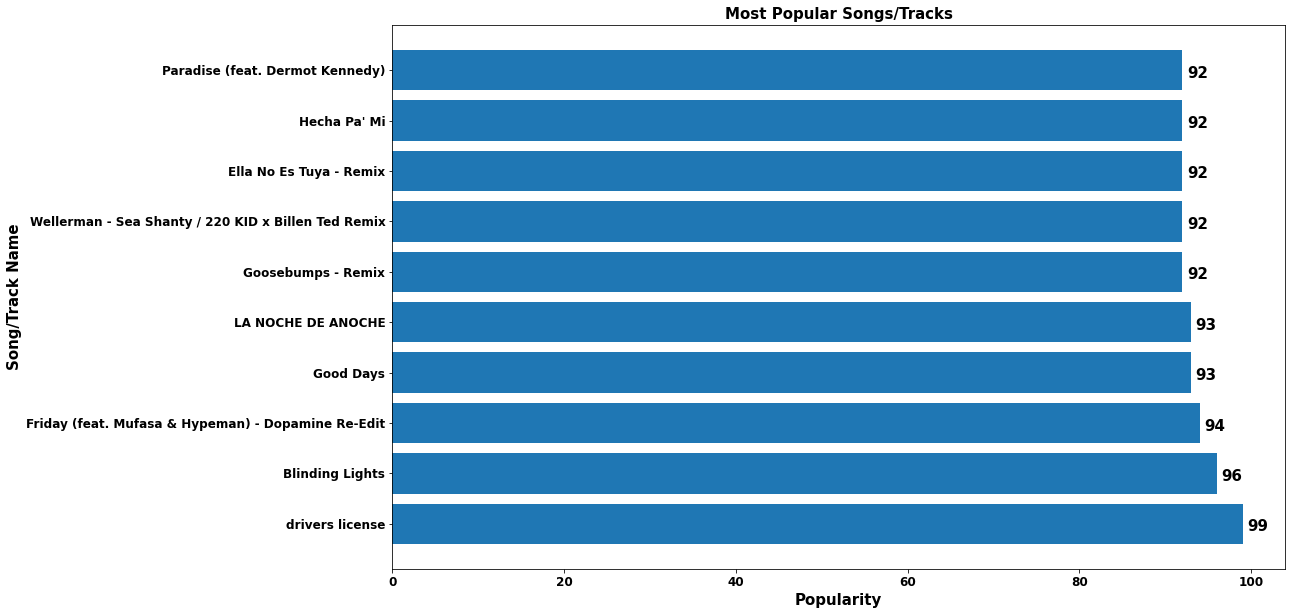

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
# Get top 10 most popular tracks
popular_songs = tracks.groupby('name')['popularity'].mean().sort_values(ascending=False).head(10)

# Plot horizontal bar chart
plt.figure(figsize=(16, 10))
plt.barh(popular_songs.index, popular_songs)
plt.title('Most Popular Songs/Tracks', fontdict=dict(fontsize=15), fontweight='bold')
plt.xlabel('Popularity', fontdict=dict(fontsize=15), fontweight='bold')
plt.ylabel('Song/Track Name', fontdict=dict(fontsize=15), fontweight='bold')
plt.xticks(fontsize='large', weight='bold')
plt.yticks(fontsize='large', weight='bold')
for i, v in enumerate(popular_songs):
    plt.text(v+0.5, i-0.15, str(int(v)), fontdict=dict(fontsize=15), fontweight='bold')
plt.show()

# Most Popular Artists

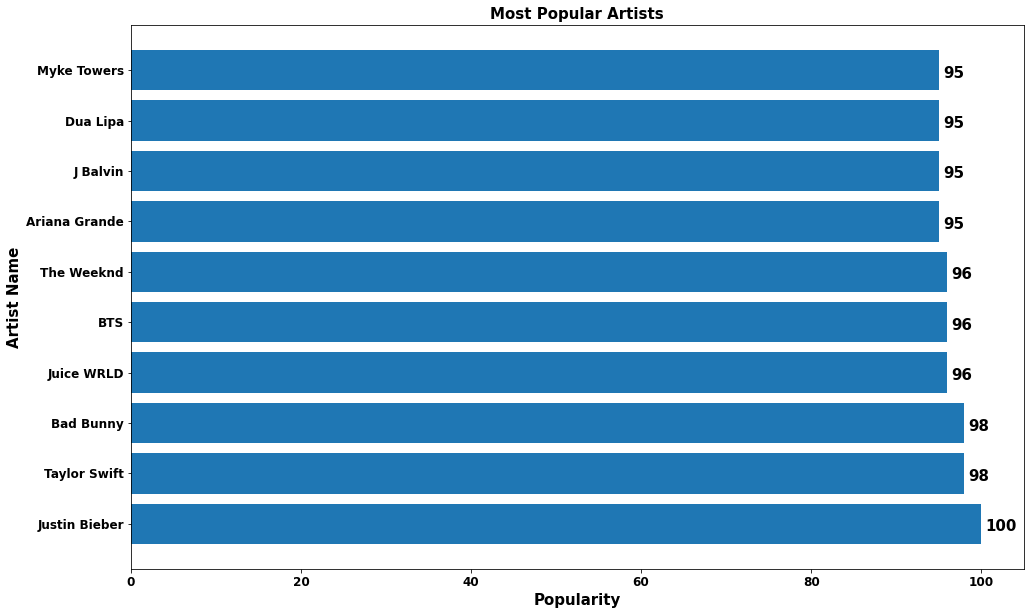

In [21]:
# Get top 10 most popular artists
popular_artists = artists.groupby('name')['popularity'].mean().sort_values(ascending=False).head(10)

# Plot horizontal bar chart
plt.figure(figsize=(16, 10))
plt.barh(popular_artists.index, popular_artists)
plt.title('Most Popular Artists', fontdict=dict(fontsize=15), fontweight='bold')
plt.xlabel('Popularity', fontdict=dict(fontsize=15), fontweight='bold')
plt.ylabel('Artist Name', fontdict=dict(fontsize=15), fontweight='bold')
plt.xticks(fontsize='large', weight='bold')
plt.yticks(fontsize='large', weight='bold')
for i, v in enumerate(popular_artists):
    plt.text(v+0.5, i-0.15, str(int(v)), fontdict=dict(fontsize=15), fontweight='bold')
plt.show()

# Top 10 genres

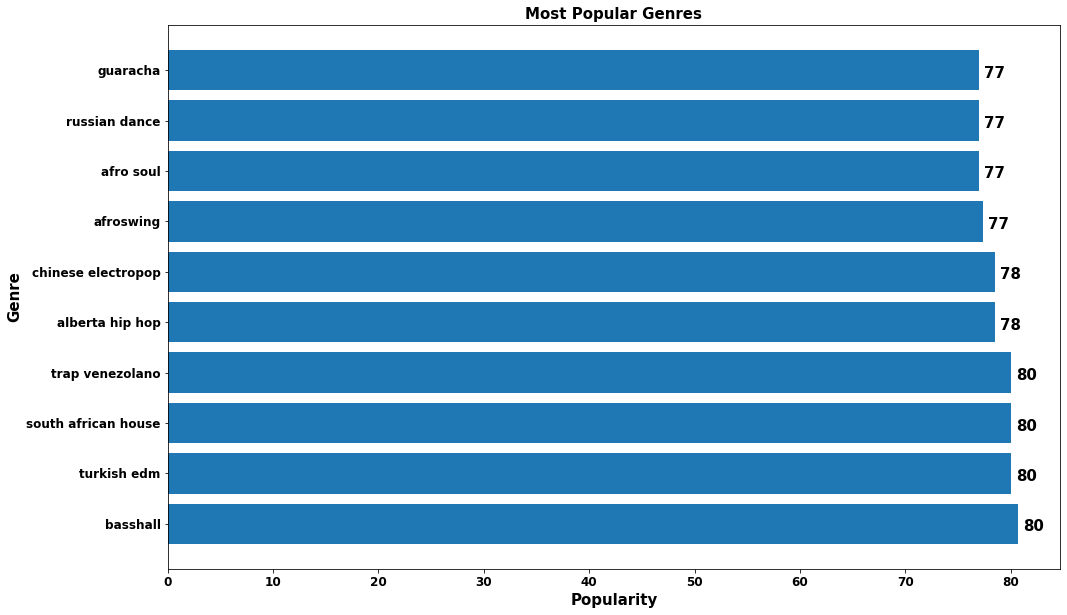

In [23]:
# Get top 10 most popular genres
popular_genres = genres.groupby('genres')['popularity'].mean().sort_values(ascending=False).head(10)

# Plot horizontal bar chart
plt.figure(figsize=(16, 10))
plt.barh(popular_genres.index, popular_genres)
plt.title('Most Popular Genres', fontdict=dict(fontsize=15), fontweight='bold')
plt.xlabel('Popularity', fontdict=dict(fontsize=15), fontweight='bold')
plt.ylabel('Genre', fontdict=dict(fontsize=15), fontweight='bold')
plt.xticks(fontsize='large', weight='bold')
plt.yticks(fontsize='large', weight='bold')
for i, v in enumerate(popular_genres):
    plt.text(v+0.5, i-0.15, str(int(v)), fontdict=dict(fontsize=15),fontweight='bold')
plt.show()